Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"rahul2july","key":"41f7f83a041e5b87c14bd2d8dfa3b88d"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [4]:
#### Steps to download from a kaggle dataset. Since we have drive location, commenting this out.
"""
#Download required dataset / competition files to a folder of your choice
!kaggle competitions download -c histopathologic-cancer-detection -p /content/gdrive/My\ Drive/kaggle/cancer

#List datasets and competitions
!kaggle datasets list   
!kaggle competitions list

#Search for datasets and competitions by name
!kaggle datasets list -s cancer
!kaggle competitions list -s histopathologic-cancer-detection

#### unzip
import os
os.chdir('gdrive/My Drive/kaggle/cancer')  #change dir
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/
!unzip -q train.zip -d train/  #unzip data in train/
!unzip -q test.zip -d test/  #unzip data in test/
!unzip sample_submission.csv.zip
!unzip train_labels.csv.zip
"""

"\n#Download required dataset / competition files to a folder of your choice\n!kaggle competitions download -c histopathologic-cancer-detection -p /content/gdrive/My\\ Drive/kaggle/cancer\n\n#List datasets and competitions\n!kaggle datasets list   \n!kaggle competitions list\n\n#Search for datasets and competitions by name\n!kaggle datasets list -s cancer\n!kaggle competitions list -s histopathologic-cancer-detection\n\n#### unzip\nimport os\nos.chdir('gdrive/My Drive/kaggle/cancer')  #change dir\n!mkdir train  #create a directory named train/\n!mkdir test  #create a directory named test/\n!unzip -q train.zip -d train/  #unzip data in train/\n!unzip -q test.zip -d test/  #unzip data in test/\n!unzip sample_submission.csv.zip\n!unzip train_labels.csv.zip\n"

#### Actual Implementation

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# Listing out all the classes of skin cancer and store them in a list. 

# We could find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


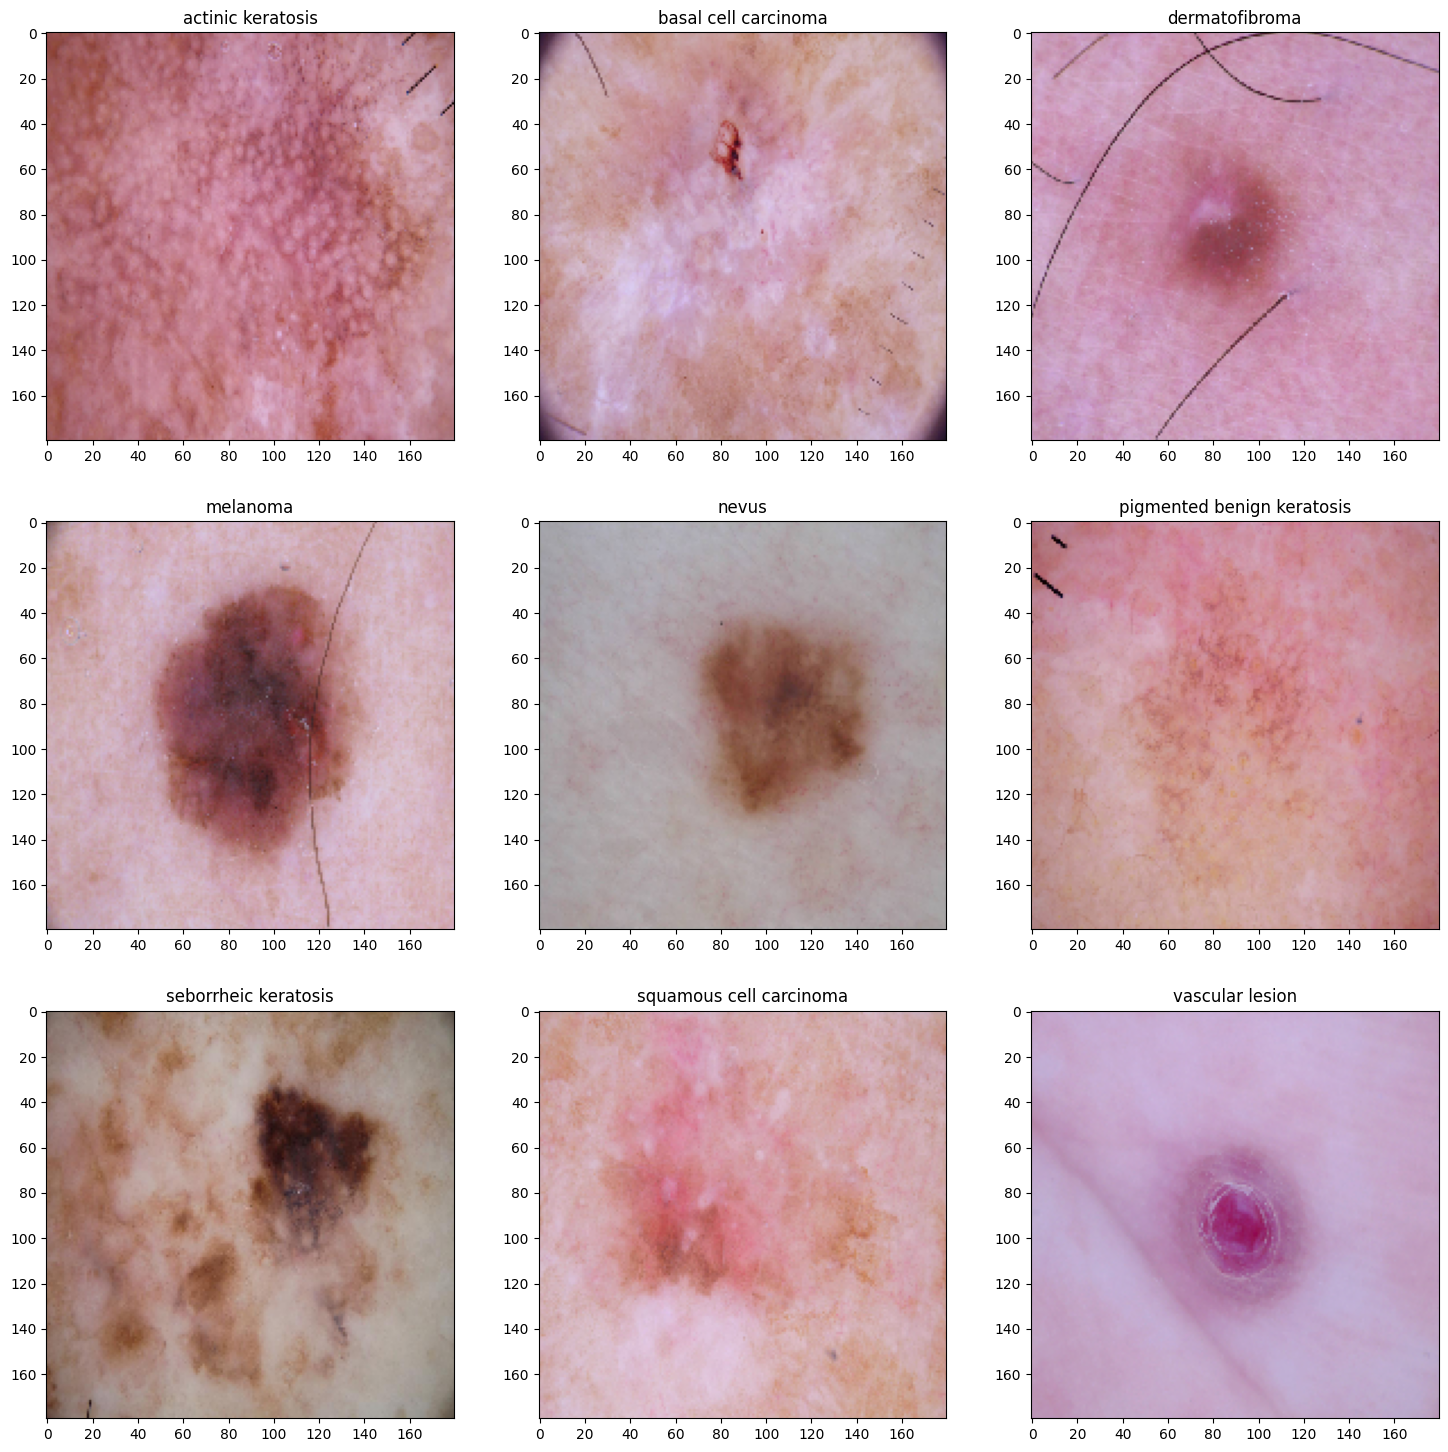

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# image_dataset_from_directory() returns a tf.data.Dataset that produces batches of images from the subdirectories.
# label_mode is categorial.
# the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)

# All classes of Skin Cancer
class_names = image_dataset.class_names

# Dictionary to store the path of image as per the class
files_path_dict = {}

for cname in class_names:
    files_path_dict[cname] = list(map(lambda x:str(data_dir_train)+'/'+cname+'/'+x,os.listdir(str(data_dir_train)+'/'+cname)))
    
#Visualize image 
plt.figure(figsize=(18,18))
index = 0

for cname in class_names:
    path_list = files_path_dict[cname][:1]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0],target_size=(img_height, img_width)))
    plt.title(cname)
    #plt.axis("off")

### Visualize distribution of classes in the training dataset.

In [14]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the cancer classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =["Cancer Class", "No. of Images"])

df = class_distribution_count(data_dir_train)
print(df)

                 Cancer Class  No. of Images
0                       nevus            357
1  pigmented benign keratosis            462
2     squamous cell carcinoma            181
3                    melanoma            438
4              dermatofibroma             95
5        seborrheic keratosis             77
6             vascular lesion            139
7           actinic keratosis            114
8        basal cell carcinoma            376


#### Visualize the Number of image in each class.

<Axes: xlabel='No. of Images', ylabel='Cancer Class'>

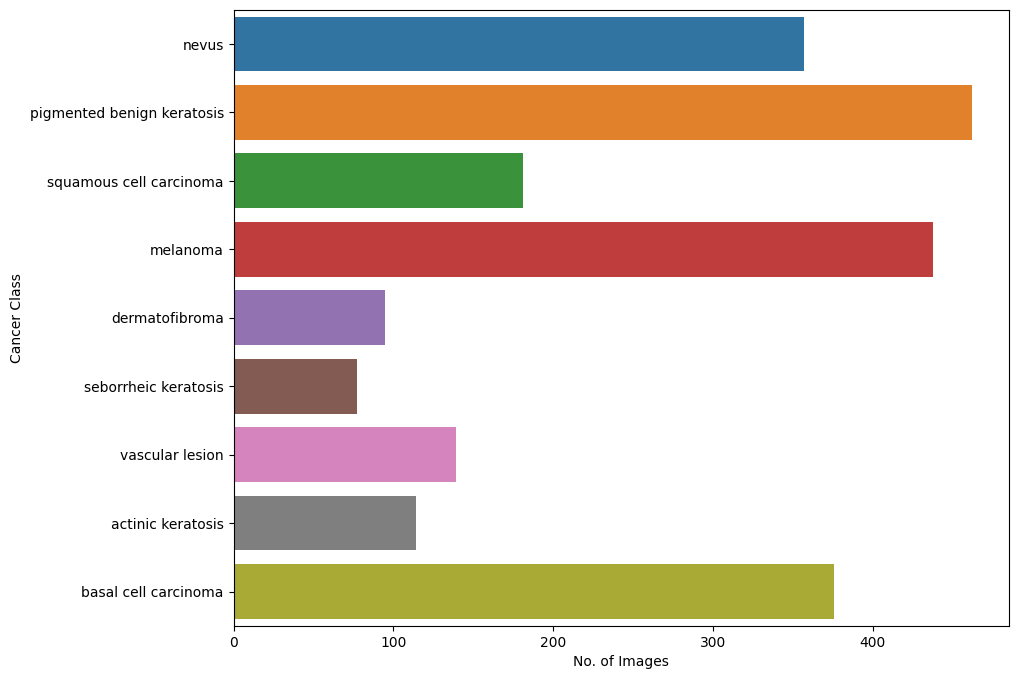

In [15]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Cancer Class", data=df,
            label="Cancer Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
# tf.data.experimental.AUTOTUNE: defines appropriate number of processes that are free for working.
# Dataset.cache(): keeps the images in memory after they're loaded off disk during the first epoch.
# Dataset.prefetch(): overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here

# CNN Model Architecture

# Sequential allows us to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Dropout layer with 50% of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer
## Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function.
# Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

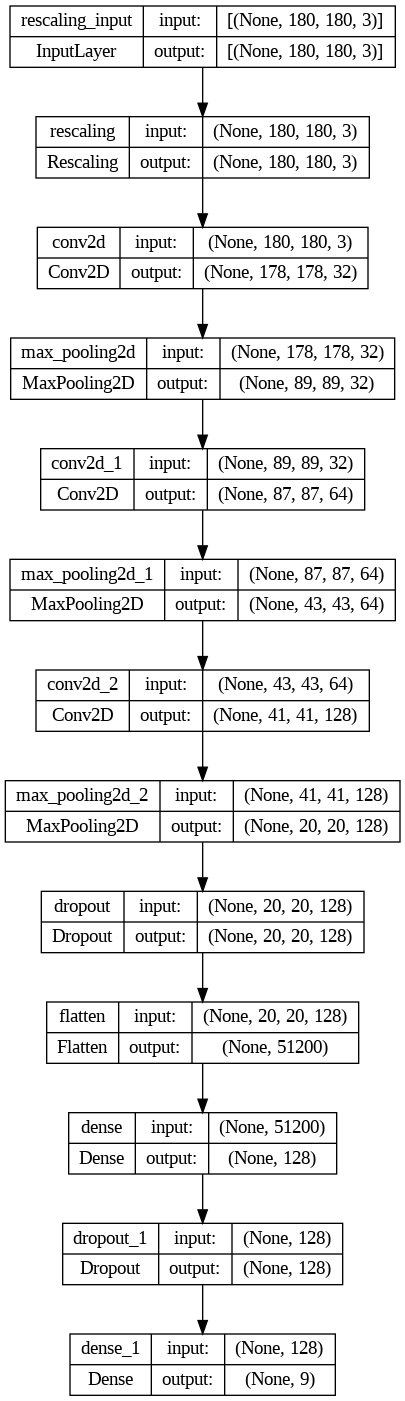

In [18]:
# Vizualizing the model 

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropriate optimiser and loss function for model training 

In [19]:
# Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer = "Adam",
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file)
# at some interval, so the model or weights can be loaded later to continue the training from the state saved.
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
#earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 649s 2s/step - loss: 1.9989 - accuracy: 0.2612 - val_loss: 1.8518 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 1.7375 - accuracy: 0.3873 - val_loss: 1.5488 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5741 - accuracy: 0.4498 - val_loss: 1.7131 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5251 - accuracy: 0.4576 - val_loss: 1.4181 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4148 - accuracy: 0.4983 - val_loss: 1.4647 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3911 - accuracy: 0.5095 - val_loss: 1.4940 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3489 - accuracy: 0.5229 - val_loss: 1.4141 - val_accuracy: 0.5056
Epoch 8/20
56

### Visualizing training results

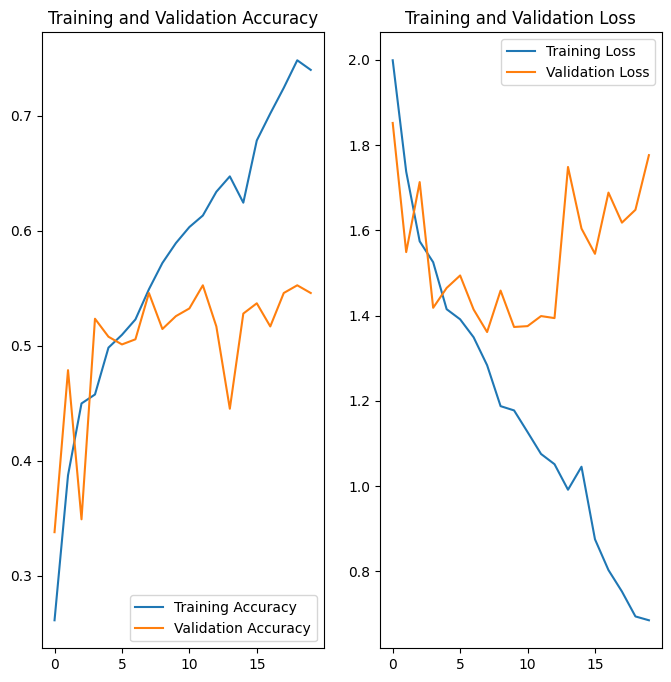

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings based on the analysis so far:

##### From the above Training vs Validation accuracy graph, we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases.
##### So it seems to be overfitting.


#### Data augumentation

In [24]:
rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range  
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)    
])

##### Visualize the augmentation image

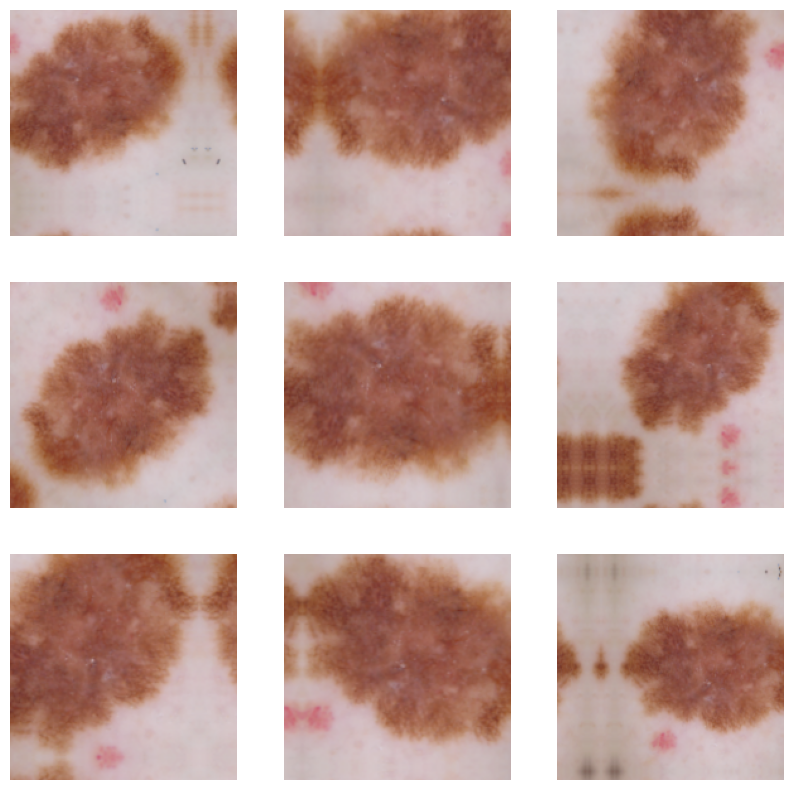

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

### Model 2 Creation

##### Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
##### which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


In [26]:
model2 = Sequential()                     # Sequential allows us to create models layer-by-layer  

model2.add(data_augmentation)             # Augmentation layer
model2.add(rescale)                       # Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

####  Compiling the model

In [27]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [28]:
## Train the model for 20 epochs
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 [==============================] - 7s 72ms/step - loss: 2.2577 - accuracy: 0.1881 - val_loss: 2.0175 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 1.9634 - accuracy: 0.2818 - val_loss: 2.0205 - val_accuracy: 0.2550
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.9704 - accuracy: 0.2645 - val_loss: 1.8502 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.8624 - accuracy: 0.3103 - val_loss: 1.7314 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.7766 - accuracy: 0.3460 - val_loss: 1.6298 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 1.7099 - accuracy: 0.3583 - val_loss: 1.8274 - val_accuracy: 0.3244
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.6674 - accuracy: 0.3800 - val_loss: 1.6676 - val_accuracy: 0.3893
Epoch 8/20
56

### Visualizing the results

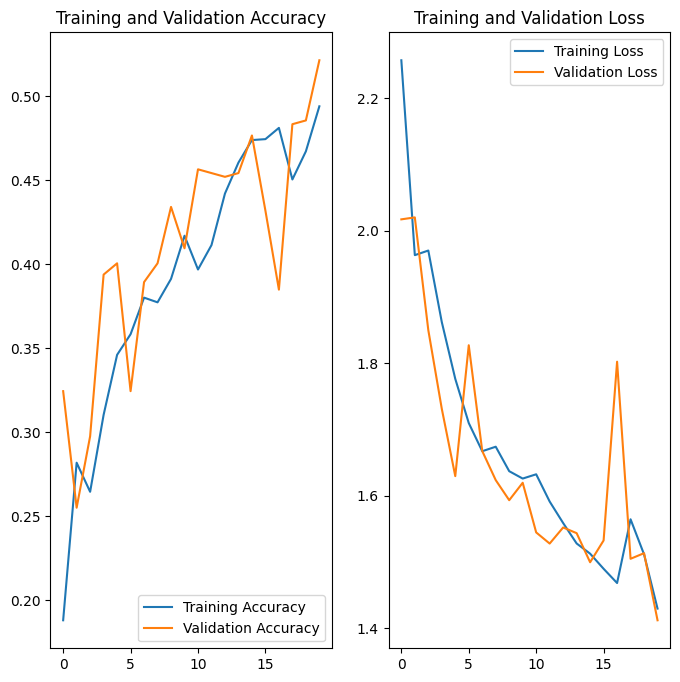

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After using data augumentation and dropout layer, overfitting issue seems to have reduced.

#### Model Performance has still not increased. 
##### Will check the distribution of classes in the training set to check is there have class imbalance.

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### Class Imbalance Detection

In [30]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
print(df)

                        Class  No. of Image
0                       nevus           357
1  pigmented benign keratosis           462
2     squamous cell carcinoma           181
3                    melanoma           438
4              dermatofibroma            95
5        seborrheic keratosis            77
6             vascular lesion           139
7           actinic keratosis           114
8        basal cell carcinoma           376


<Axes: xlabel='No. of Image', ylabel='Class'>

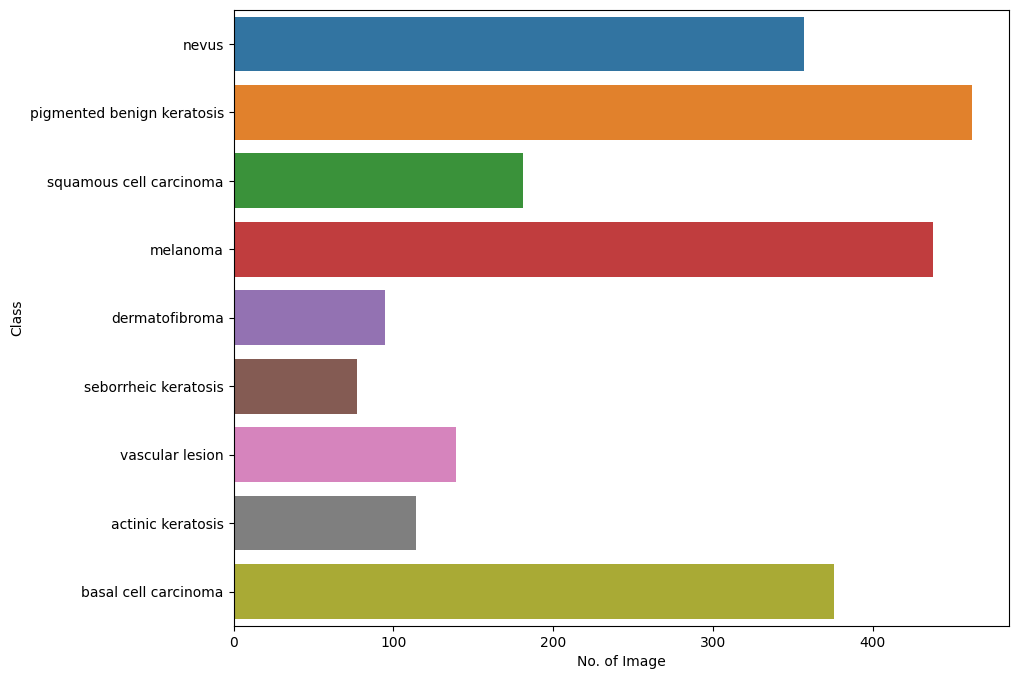

In [31]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### "seborrheic keratosis" has the least number of samples. It is 77.

#### Following class dominates the data in terms proportionate number of samples:
##### - pigmented benign keratosis (462 Samples) 
##### - melanoma (438 Samples)
##### - basal cell carcinoma (376 Samples)
##### - nevus (357 Samples) 

#### Rectifying the class imbalance
#### **Context:** Using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In order to use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
import Augmentor

path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" 

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC86B7150D0>: 100%|██████████| 500/500 [00:25<00:00, 19.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC86B6D3BB0>: 100%|██████████| 500/500 [00:27<00:00, 17.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC86B7189D0>: 100%|██████████| 500/500 [00:25<00:00, 19.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC86B6F05E0>: 100%|██████████| 500/500 [01:49<00:00,  4.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FC86B6AAF70>: 100%|██████████| 500/500 [01:37<00:00,  5.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC90476D970>: 100%|██████████| 500/500 [00:24<00:00, 20.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC85B1B9B50>: 100%|██████████| 500/500 [00:46<00:00, 10.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC9047A39D0>: 100%|██████████| 500/500 [00:22<00:00, 22.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC85B184FD0>: 100%|██████████| 500/500 [00:21<00:00, 22.86 Samples/s]


##### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. 
##### Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))

4500


In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
# Dataframe storing path and label of the images generated by Augmentor
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df.head()

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,nevus
1,/content/drive/MyDrive/Skin cancer ISIC The In...,nevus
2,/content/drive/MyDrive/Skin cancer ISIC The In...,nevus
3,/content/drive/MyDrive/Skin cancer ISIC The In...,nevus
4,/content/drive/MyDrive/Skin cancer ISIC The In...,nevus


In [39]:
new_df['Label'].value_counts()

nevus                         500
pigmented benign keratosis    500
squamous cell carcinoma       500
melanoma                      500
dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
actinic keratosis             500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [41]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  label_mode='categorical', # means that the labels are encoded as a categorical vector 
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical', # means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [43]:

#Model

model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile the model 

In [44]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### Train the model

In [45]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 52s 270ms/step - loss: 2.3930 - accuracy: 0.2018 - val_loss: 3.7292 - val_accuracy: 0.1463
Epoch 2/50
169/169 [==============================] - 36s 209ms/step - loss: 1.8187 - accuracy: 0.3299 - val_loss: 3.8552 - val_accuracy: 0.1633
Epoch 3/50
169/169 [==============================] - 36s 207ms/step - loss: 1.5982 - accuracy: 0.3973 - val_loss: 2.3650 - val_accuracy: 0.2806
Epoch 4/50
169/169 [==============================] - 37s 213ms/step - loss: 1.4940 - accuracy: 0.4364 - val_loss: 1.8990 - val_accuracy: 0.3734
Epoch 5/50
169/169 [==============================] - 34s 194ms/step - loss: 1.4464 - accuracy: 0.4505 - val_loss: 1.5081 - val_accuracy: 0.4083
Epoch 6/50
169/169 [==============================] - 37s 212ms/step - loss: 1.3731 - accuracy: 0.4868 - val_loss: 1.5698 - val_accuracy: 0.3950
Epoch 7/50
169/169 [==============================] - 34s 194ms/step - loss: 1.3684 - accuracy: 0.4805 - val_loss: 1.3214 - val_ac

#### Visualize the model results

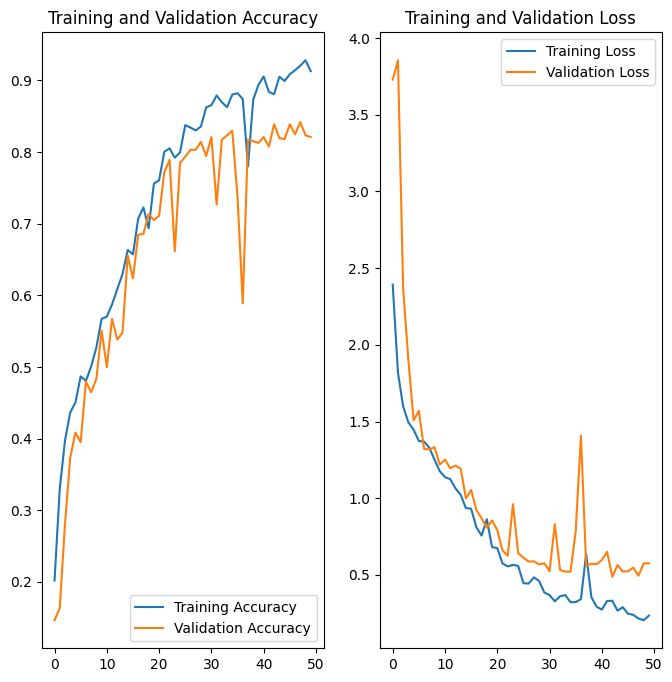

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis based on the model and results:
As per the final model (model3):
1. training accuracy and validation accuracy has increased.
2. Model overfitting issue is solved.
3. Class rebalance helps in augmentation and achieving the best training and validation accuracy.
